In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
label_map = {
    0 : ['unlabeled', 255, 'void'], 
    1 : ['ego vehicle', 255, 'void'],
    2 : ['rectification border', 255, 'void'],
    3 : ['out of roi', 255, 'void'],
    4 : ['static', 255, 'void'],
    5 : ['dynamic', 255, 'void'],
    6 : ['ground', 255, 'void'],
    7 : ['road', 0, 'flat'],
    8 : ['sidewalk', 1, 'flat'],
    9 : ['parking', 255, 'flat'],
    10 : ['rail track', 255, 'flat'],
    11 : ['building', 2, 'construction'],
    12 : ['wall', 3, 'construction'],
    13 : ['fence', 4, 'construction'],
    14 : ['guard rail', 255, 'construction'],
    15 : ['bridge', 255, 'construction'],
    16 : ['tunnel', 255, 'construction'],
    17 : ['pole', 5, 'object'],
    18 : ['polegroup', 255, 'object'],
    19 : ['traffic light', 6, 'object'],
    20 : ['traffic sign', 7, 'object'],
    21 : ['vegetation', 8, 'nature'],
    22 : ['terrain', 9, 'nature'],
    23 : ['sky', 10, 'sky'],
    24 : ['person', 11, 'human'],
    25 : ['rider', 12, 'human'],
    26 : ['car', 13, 'vehicle'],
    27 : ['truck', 14, 'vehicle'],
    28 : ['bus', 15, 'vehicle'],
    29 : ['caravan', 255, 'vehicle'],
    30 : ['trailer', 255, 'vehicle'],
    31 : ['train', 16, 'vehicle'],
    32 : ['motorcycle', 17, 'vehicle'],
    33 : ['bicycle', 18, 'vehicle'],
    34 : ['license plate', -1, 'vehicle']
}

In [3]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in label_map:
            encx[x == label] = label_map[label][1] if label_map[label][1] != 255 else 19
        return F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "train", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

valid_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "val", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform    
)

test_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "test", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 2975
#Validation Samples: 500
#Testing Samples: 1525
#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


Total #Classes: 20
data shape: torch.Size([3, 256, 512])
mask shape: torch.Size([20, 256, 512])
Number classes: 20
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19])


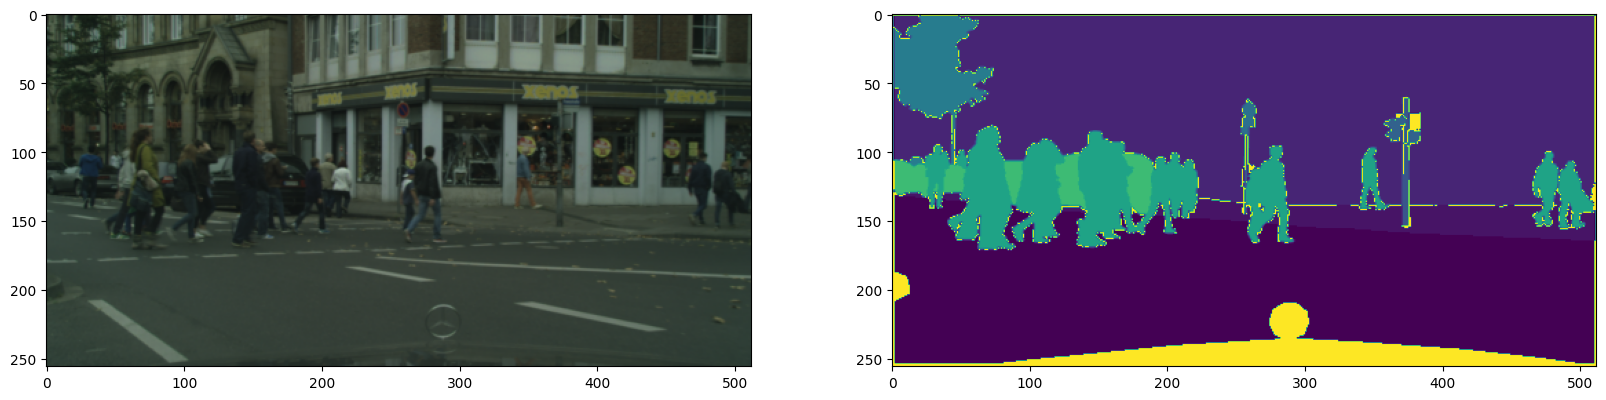

In [5]:
sample_data, sample_mask = train_ds[19]
total_num_class = 20

print(f"Total #Classes: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
from typing import *
class FocalLoss(nn.Module):
    def __init__(self, gamma: int, weights: list[float] = None, reduction = 'mean'):
        super().__init__()

        if weights is not None:
            self.weights = torch.from_numpy(np.array(weights)).view(-1, len(weights), 1, 1)
        else:
            self.weights = None 

        self.gamma = gamma
        self.reduc = reduction

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):

        if self.weights is None:
            self.weights = torch.ones(1, targets.shape[1], 1, 1).to(targets.device)
        else:
            self.weights = self.weights.to(targets.device)
        
        coeff = torch.pow(1 - preds, self.gamma)

        loss = -torch.log(nn.Softmax(-1)(preds))*targets*self.weights

        focal_loss = loss * coeff

        if self.reduc == 'none':
            return focal_loss
        elif self.reduc == 'class_sum':
            return focal_loss.sum(1)
        elif self.reduc == 'sum':
            return focal_loss.sum()
        elif self.reduc == 'mean':
            return focal_loss.mean()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, total_num_class, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = FocalLoss(gamma = 2)

In [14]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


Epoch: 0 - TrainLoss: 1.045229841944992 - ValidLoss: 0.93440942466259


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 1 - TrainLoss: 0.8736651873075834 - ValidLoss: 0.804852269589901


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 2 - TrainLoss: 0.7454034019541996 - ValidLoss: 0.6970181278884411


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 3 - TrainLoss: 0.6476935468694215 - ValidLoss: 0.650983452796936


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch: 4 - TrainLoss: 0.5936648179126042 - ValidLoss: 0.6257834546267986


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch: 5 - TrainLoss: 0.5537274999003257 - ValidLoss: 0.6446984484791756


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Epoch: 6 - TrainLoss: 0.5188059749141816 - ValidLoss: 0.5329866260290146


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch: 7 - TrainLoss: 0.4937972929528964 - ValidLoss: 0.5599676892161369


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 8 - TrainLoss: 0.48821947683570205 - ValidLoss: 0.5472270213067532


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch: 9 - TrainLoss: 0.47461219660697446 - ValidLoss: 0.5021472740918398


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch: 10 - TrainLoss: 0.46423879682376823 - ValidLoss: 0.5122281294316053


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch: 11 - TrainLoss: 0.45060954170842327 - ValidLoss: 0.5005398560315371


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 12 - TrainLoss: 0.4361556662667182 - ValidLoss: 0.4947131387889385


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Epoch: 13 - TrainLoss: 0.4319599559230189 - ValidLoss: 0.46620768308639526


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch: 14 - TrainLoss: 0.4298168564996412 - ValidLoss: 0.501730652526021


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Epoch: 15 - TrainLoss: 0.42123898607428356 - ValidLoss: 0.47762878239154816


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


Epoch: 16 - TrainLoss: 0.4172215541844727 - ValidLoss: 0.46912338770926


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 17 - TrainLoss: 0.40721466945063683 - ValidLoss: 0.47549523413181305


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 18 - TrainLoss: 0.39738841402915215 - ValidLoss: 0.4612031579017639


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 19 - TrainLoss: 0.39356273124294894 - ValidLoss: 0.44484987296164036


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.29s/it]


Epoch: 20 - TrainLoss: 0.38061268355256767 - ValidLoss: 0.4754044581204653


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 21 - TrainLoss: 0.37196471229676276 - ValidLoss: 0.46228110045194626


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 22 - TrainLoss: 0.3754021563837605 - ValidLoss: 0.44181870855391026


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch: 23 - TrainLoss: 0.36199086872480246 - ValidLoss: 0.45140056125819683


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 24 - TrainLoss: 0.35525893299810346 - ValidLoss: 0.41860998421907425


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch: 25 - TrainLoss: 0.35022235397369633 - ValidLoss: 0.44186827540397644


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Epoch: 26 - TrainLoss: 0.34655028485482736 - ValidLoss: 0.423175485804677


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


Epoch: 27 - TrainLoss: 0.3398284969791289 - ValidLoss: 0.41642075031995773


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 28 - TrainLoss: 0.3307012899588513 - ValidLoss: 0.4381510205566883


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 29 - TrainLoss: 0.32577776267964353 - ValidLoss: 0.5610541347414255


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch: 30 - TrainLoss: 0.3220087562196998 - ValidLoss: 0.4700061306357384


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 31 - TrainLoss: 0.31759030235710967 - ValidLoss: 0.48391737788915634


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch: 32 - TrainLoss: 0.32244431139320456 - ValidLoss: 0.44805658981204033


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 33 - TrainLoss: 0.3116045315419474 - ValidLoss: 0.45444498769938946


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 34 - TrainLoss: 0.3012011759383704 - ValidLoss: 0.501276420429349


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


Epoch: 35 - TrainLoss: 0.3051011559142861 - ValidLoss: 0.530319344252348


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch: 36 - TrainLoss: 0.29845449552741105 - ValidLoss: 0.5081467665731907


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


Epoch: 37 - TrainLoss: 0.2927887196181923 - ValidLoss: 0.49636092968285084


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 38 - TrainLoss: 0.29037154778357477 - ValidLoss: 0.5917864069342613


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch: 39 - TrainLoss: 0.302573827966567 - ValidLoss: 0.5041725169867277


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.96s/it]


Epoch: 40 - TrainLoss: 0.2894869701516244 - ValidLoss: 0.4850102700293064


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Epoch: 41 - TrainLoss: 0.28238371623459685 - ValidLoss: 0.5254329722374678


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 42 - TrainLoss: 0.281406369741245 - ValidLoss: 0.4815224055200815


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 43 - TrainLoss: 0.2726668850068123 - ValidLoss: 0.5189990680664778


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 44 - TrainLoss: 0.2700742574468736 - ValidLoss: 0.5603389889001846


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 45 - TrainLoss: 0.2692687234250448 - ValidLoss: 0.6244317218661308


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch: 46 - TrainLoss: 0.2666928492566591 - ValidLoss: 0.6202679891139269


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 47 - TrainLoss: 0.2706232678185227 - ValidLoss: 0.6299244221299887


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 48 - TrainLoss: 0.26316119698427054 - ValidLoss: 0.5627575293183327


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 49 - TrainLoss: 0.2614983019008431 - ValidLoss: 0.5637052357196808


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 50 - TrainLoss: 0.266787021871536 - ValidLoss: 0.5847596134990454


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch: 51 - TrainLoss: 0.25351649602895143 - ValidLoss: 0.5500139612704515


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch: 52 - TrainLoss: 0.25365338017863615 - ValidLoss: 0.6447572968900204


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 53 - TrainLoss: 0.2476195757107068 - ValidLoss: 0.7011304628103971


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch: 54 - TrainLoss: 0.24670201459879515 - ValidLoss: 0.6262296549975872


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


Epoch: 55 - TrainLoss: 0.24443367187694837 - ValidLoss: 0.6752027496695518


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


Epoch: 56 - TrainLoss: 0.2435574116565848 - ValidLoss: 0.662195947021246


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


Epoch: 57 - TrainLoss: 0.23773496606016672 - ValidLoss: 0.7098543532192707


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch: 58 - TrainLoss: 0.2361902701918797 - ValidLoss: 0.7586897760629654


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


Epoch: 59 - TrainLoss: 0.23508787347424415 - ValidLoss: 0.7828286625444889


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 60 - TrainLoss: 0.2379662799899296 - ValidLoss: 0.7148790154606104


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:32<00:00,  2.03s/it]


Epoch: 61 - TrainLoss: 0.23890283607667492 - ValidLoss: 0.8102174215018749


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch: 62 - TrainLoss: 0.2344694278573477 - ValidLoss: 0.7539631724357605


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 63 - TrainLoss: 0.23424189081115107 - ValidLoss: 0.7407441660761833


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


Epoch: 64 - TrainLoss: 0.2288078994199794 - ValidLoss: 0.844628568738699


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 65 - TrainLoss: 0.22635313724317857 - ValidLoss: 0.7797347065061331


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 66 - TrainLoss: 0.22445005130383275 - ValidLoss: 0.8914601132273674


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch: 67 - TrainLoss: 0.22100825287321563 - ValidLoss: 0.9155300240963697


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


Epoch: 68 - TrainLoss: 0.2207222209181837 - ValidLoss: 0.9576503597199917


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


Epoch: 69 - TrainLoss: 0.22189828593243835 - ValidLoss: 0.864727109670639


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


Epoch: 70 - TrainLoss: 0.21951676921177937 - ValidLoss: 0.9916634634137154


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 71 - TrainLoss: 0.21978965321535704 - ValidLoss: 0.8800863474607468


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Epoch: 72 - TrainLoss: 0.21752542561741287 - ValidLoss: 0.95991375669837


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch: 73 - TrainLoss: 0.21528616515539026 - ValidLoss: 0.959464892745018


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 74 - TrainLoss: 0.21506292092543777 - ValidLoss: 0.9501533433794975


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 75 - TrainLoss: 0.21392242786704854 - ValidLoss: 0.9983235485851765


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 76 - TrainLoss: 0.214955840059506 - ValidLoss: 0.9891911409795284


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.47s/it]


Epoch: 77 - TrainLoss: 0.21423521349506994 - ValidLoss: 0.9712653420865536


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


Epoch: 78 - TrainLoss: 0.21234615980297006 - ValidLoss: 1.046735942363739


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 79 - TrainLoss: 0.21340383733472518 - ValidLoss: 1.001112962141633


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Epoch: 80 - TrainLoss: 0.21180663105621134 - ValidLoss: 1.0375198684632778


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch: 81 - TrainLoss: 0.21010140209428727 - ValidLoss: 1.0033640637993813


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.94s/it]


Epoch: 82 - TrainLoss: 0.2095742001328417 - ValidLoss: 1.0144226774573326


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Epoch: 83 - TrainLoss: 0.20911491894593803 - ValidLoss: 1.0718241333961487


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 84 - TrainLoss: 0.20883658336054894 - ValidLoss: 1.0938871428370476


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 85 - TrainLoss: 0.20796416796022846 - ValidLoss: 1.1043773479759693


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 86 - TrainLoss: 0.20786758440156136 - ValidLoss: 1.0736138932406902


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 87 - TrainLoss: 0.20800828180646383 - ValidLoss: 1.0939528793096542


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.63s/it]


Epoch: 88 - TrainLoss: 0.20737144318960046 - ValidLoss: 1.0805948972702026


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 89 - TrainLoss: 0.20635133981704712 - ValidLoss: 1.080415777862072


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 90 - TrainLoss: 0.20707440312190722 - ValidLoss: 1.0754389092326164


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


Epoch: 91 - TrainLoss: 0.2066202501776398 - ValidLoss: 1.1095334067940712


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 92 - TrainLoss: 0.20602550333546055 - ValidLoss: 1.1027816906571388


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch: 93 - TrainLoss: 0.2060285287518655 - ValidLoss: 1.0734046511352062


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


Epoch: 94 - TrainLoss: 0.20596037019965469 - ValidLoss: 1.085301499813795


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


Epoch: 95 - TrainLoss: 0.20616468450715464 - ValidLoss: 1.0652247332036495


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch: 96 - TrainLoss: 0.2059197413024082 - ValidLoss: 1.0862840339541435


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 97 - TrainLoss: 0.20577778034312752 - ValidLoss: 1.1032092981040478


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Epoch: 98 - TrainLoss: 0.20629967108208647 - ValidLoss: 1.1087827198207378


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]

Epoch: 99 - TrainLoss: 0.2056722253240565 - ValidLoss: 1.0991394855082035


<All keys matched successfully>

In [15]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|██████████████████████████████████████████████████████████████████████| 48/48 [01:38<00:00,  2.04s/it]

TestLoss: 24.3456369638443


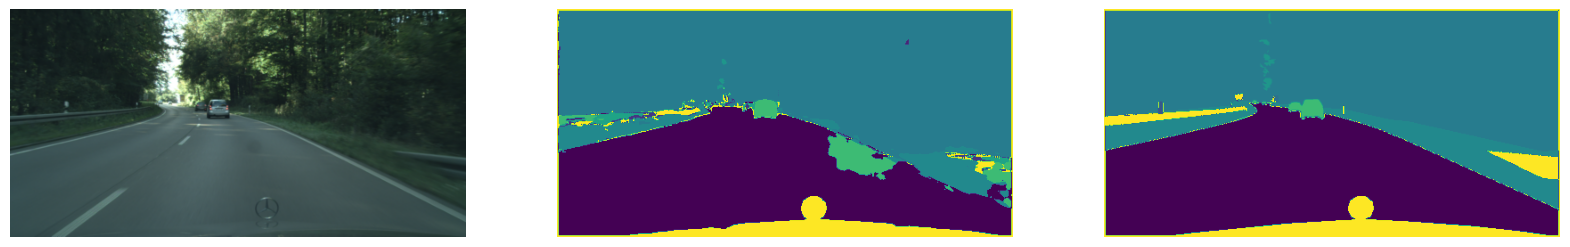

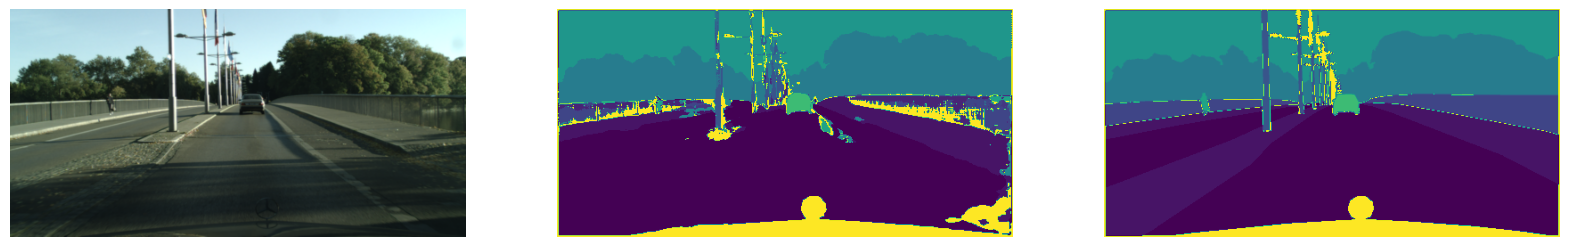

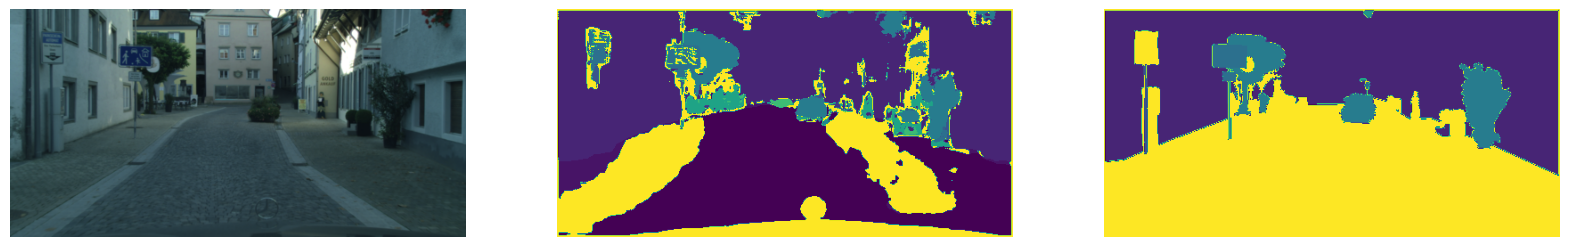

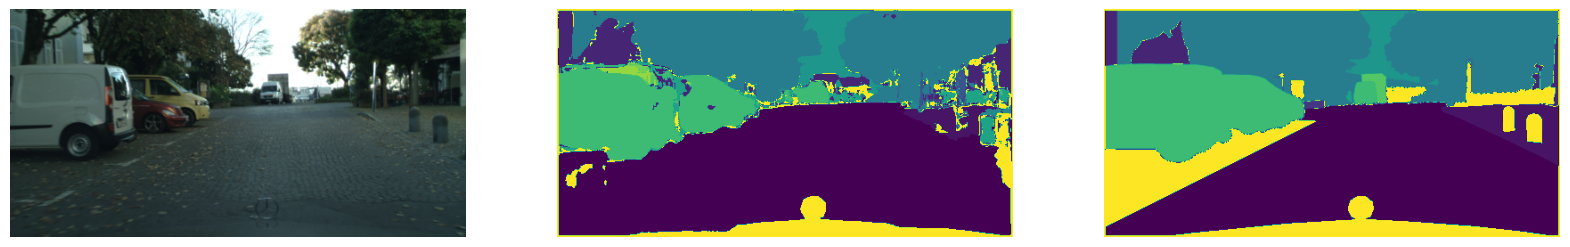

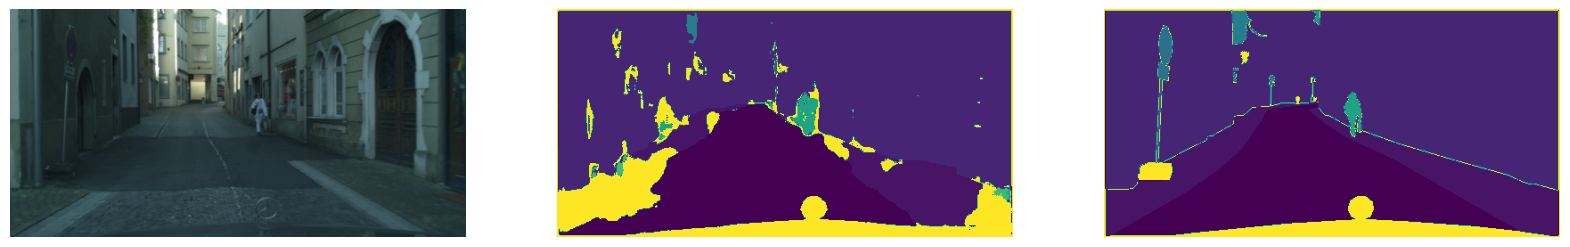

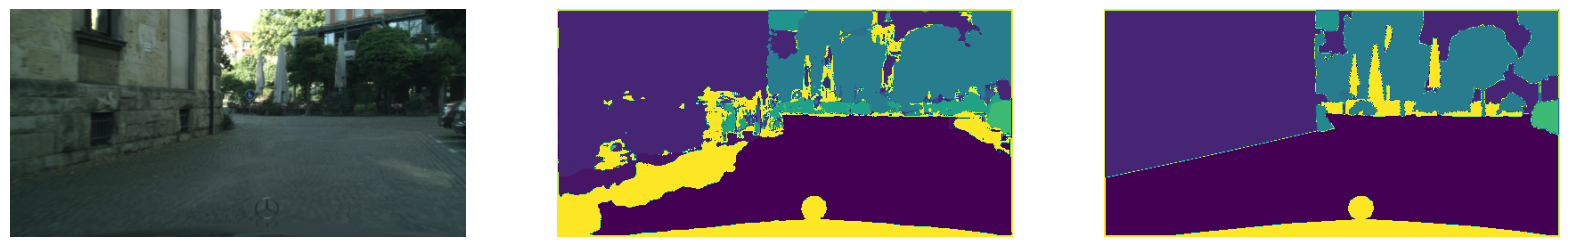

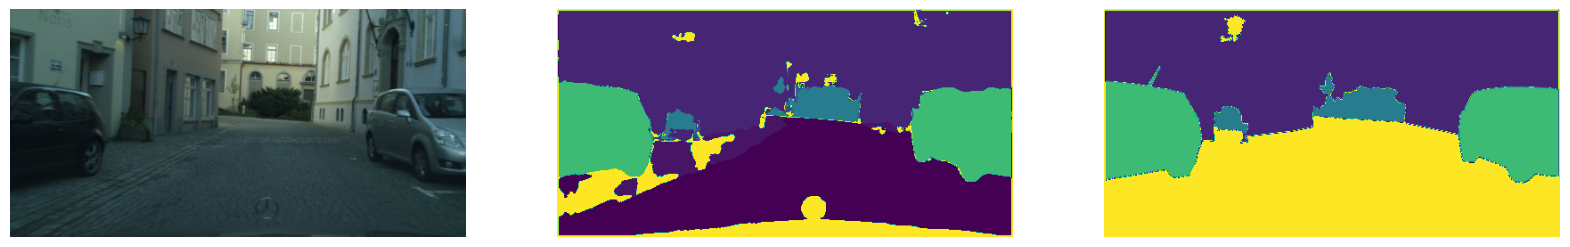

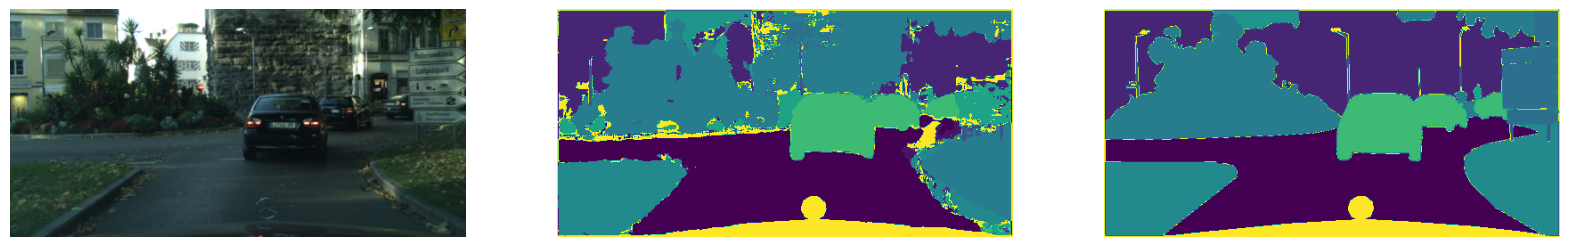

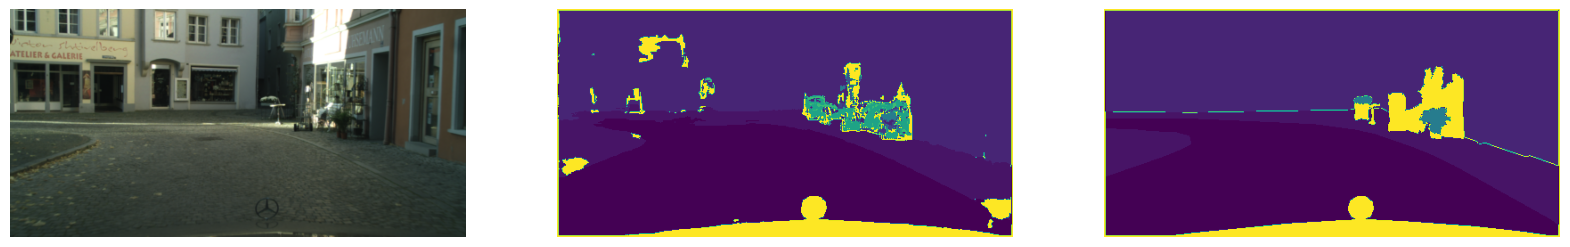

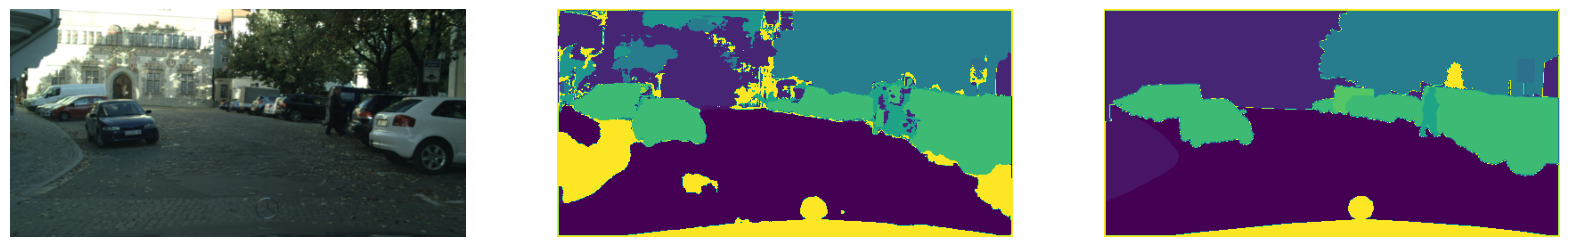

In [18]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = valid_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')